# AlphaGo Zero: Mastering the game of Go without human knowledge

In October 2015 DeepMind's __AlphaGo Fan__ beat the European Go champion [Fan Hui](https://en.wikipedia.org/wiki/Fan_Hui) in the game of Go decisively and just one year later __AlphaGo Lee__ defeated [Lee Sedol](https://de.wikipedia.org/wiki/Lee_Sedol) who is considered to be one of the greatest Go players of the past decade. This shows the world the potential of RL algorithms to outperform humans in a highly complex game which requres strategy and thinking ahead. Since then, DeepMind has further refined the architecture behind AlphaGo, creating new versions with vastly improved performance. __AlphaGo Zero__ is one such newer version that surpassed all the previous versions of AlphaGo in a fairly short amount of time. <br>
This blogpost is meant to give the reader a basic understanding of the underlying architecture of AlphaGo Zero and to showcase the elegance of the interplay between the utilized algorithms.

### The game of Go

Go is an old chinese boardgame played by two players who take alternating turns. The game is played on a 19x19 grid. On each turn the player places a stone on an intersection or the player chooses to pass with the goal of surrounding as much territory on the board as possible by the time the game concludes. One side uses the black pieces while the other uses the white pieces. Today the game is widely popular in East Asia and is regarded to be very complex, being very difficult, if not impossible, to master.

## The outstanding idea behind AlphaGo Zero

The core difference between AlphaGo Zero and its predecessor AlphaGo is that its knowledge is solely based on playing against itself without **any** prior human knowledge or supervision and it means that it is basically starting from scratch or as some would say _"tabula rasa"_ which roughly translates to blank or clean slate.<br>
To provide a better initial understanding about the idea of AlphaGo Zero we can describe the steps of its algorithm in simple ways. <br>

The following terms should give you an idea on how one person would approach a game with only knowing its rules and nothing else:
### Foresight
Imagine we have the board of a game in front of us. The first step we would take is going through possible scenarios that could impact on how the game plays out. Naturally, the priority lies on which path or state could benefit us the most and the reaction of our opponent to our own actions. We obviously can not always predict every move that our opponent could take or how the game will play out after we take an action correctly but it gives us a good understanding of the possible scenarios. 

### Exploration
Every time we reach a new state we want to understand how valuable the state is and for each state it is necessary to revert the path that led you to the state so that we can memorize the procedure and the possible use for our actions in this match or even future matches. The value can certainly change over the time by playing and re-evaluating.

### Decision
When he have finished evaluating and playing mentally through the possible states and paths we can take an action according to our gained knowledge of the game which means we will take the action that we have explored the most, because this would be the route that we have gained the most knowledge from. By learning and gaining more knowledge our decisions in the same state could vary and change accordingly.

### Evaluation
In our final evaluation, which happens at the end of the game, we want to review our performance of the game by evaluating our mistakes and misjudgements for the values of certain states. We should also take a look at where we have judged correctly so that we can repeat this possible step again.<br>
After the evaluation we now have a better understanding of the game and we can take on the next match with our updated knowledge.     

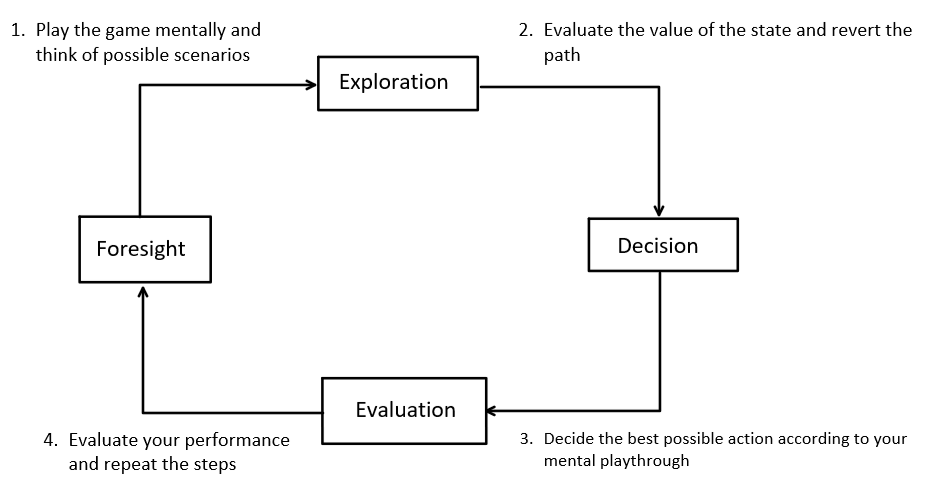<br>

As you can see these steps depict on how we generally learn to play a game and it is not limited to the game of Go, you can apply this procedure on as good as every game e.g. Chess, Shogi, .. etc.<br>
However for this post we want to focus on AlphaGo Zero specifically and in the next section it will be a deeper delve on how Reinforment Learning is applied on AlphaGo Zero and how deep neural networks that uses the raw board representations comes into play.<br>


## Reinforcement Learning in AlphaGo Zero


AlphaGo Zero utilizes two main components, a **deep neural network** $f_\theta$ with parameters $\theta$ and a **Monte Carlo tree search alogrithm (MCTS)**. The deep neural network takes the raw board representation of the current board and of previous boardstates combined into one state $s$ as input to predict a probability for each move of the given boardstate, encoded as a vector $p$, and to predict the chance of victory $v$ for the current player, $(p, v) = f_\theta(s)$. Each move (action) $a$ the player may choose when in boardstate $s$ can be viewed in combination as a tuple $(s, a)$.

Only the parameters $\theta$ of the deep neural network are trained, improving the performance of AlphaGo Zero.

When asked to choose its next move $a$ in boardstate $s$, the algorithm will conduct a MCTS using the deep neural network. This utilizes a tree in which each node is a boardstate $s$ and each edge is the combination of a boardstate and a move $(s, a)$. 

Each edge also contains a counter $N(s, a)$ how often the edge was chosen during the search. Further the edge contains a value $P(s, a)$ derived from pthe probability vector of the neural network $(P(s, \cdot), V(s)) = f_\theta(s)$. Note that the neural network also supplies us a value function $V(s)$ for a the current boardstate. Lastly each edge contains the action value $Q(s, a)$ derived from the value funvtion $V(s')$ of the resulting boardstate $s'$ after action $a$ was chosen and the opposing player has finished his turn.

So to sum up: Each edge $(s, a)$ contains so far three values $N(s, a), P(s, a), Q(s, a)$. Now, we can calculate how promising the state-action pair is as $Q(s, a) + U(s, a)$, in which $U(s, a) \propto \frac{P(s, a)}{N(s, a) + 1}$. The function $U(s, a)$ can be viewed as the tool which balances the exploration and the exploitation aspects of the algorithm.

Let $s_0$ be the boardstate at the start of the MCTS. In practise, the MCTS then does the following:

1. Initialize the tree with a single node: The current boardstate $s_0$ and its edges $(s_0, a)$.

2. Search the tree by following the most promising path, i.e. always choose to follow the edge $(s, a)$ with the higheset value of $Q(s, a) + U(s, a)$). Do this until an edge $(s, a)$ is selected which leads to a boardstate $s'$ which has not yet been recorded in the tree. (Step 1. in the idea diagram)

3. Expand the tree by giving the new boardstate $s'$ it's own node and increase the counter $N(s, a)$ as well as update $Q(s, a)$ for each edge that lead to this new boardstate by one. (Step 2. in the idea diagram)

4. If computation time is remaining till the move has to be selected jump to step 2. Else return a stochastic policy $\pi(a | s_0) \propto N(s_0, a)^{\frac{1}{\tau}}$ using the hyperparameter $\tau$. This policy $\pi(a | s_0)$ recommends possible moves by assigning each a probability proportional to the exponentiated number of visits of the respective edge $(s_0, a)$.

5. The next move can then be derived from the given policy $\pi(a | s_0)$. (Step 3. in the idea diagram)

The resulting policy $\pi(a | s_0)$ can be viewed as a refinement of the raw network output probatilites $p$, $(p, v) = f_\theta(s_0)$.

Using this process the algorithm can play against itself over and over again. After each self-play match has conluded, the match history can be used to construct muliple triples $(s, \pi(\cdot| s), z)$ each containing a boardstate $s$, the MCTS move probabilities (i.e. the returned policy) for this boardstate $\pi(\cdot| s)$, and an encoding of the eventual winner of the match $z$ (did the player whose turn it is in the boardstate $s$ win?). 

After multiple of these self-plays have conluded, a batch from the available triples is chosen to be used in training the deep neural network. The network is trained for each triple $(s, \pi(\cdot| s), z)$ in the batch. The training minimizes the error between the network output, the MCTS policy and the eventual winner so that $f_\theta(s) = (p, v) \sim (\pi(\cdot| s), z)$. (Step 4. in the idea diagram)

We can visualize this process as follows:

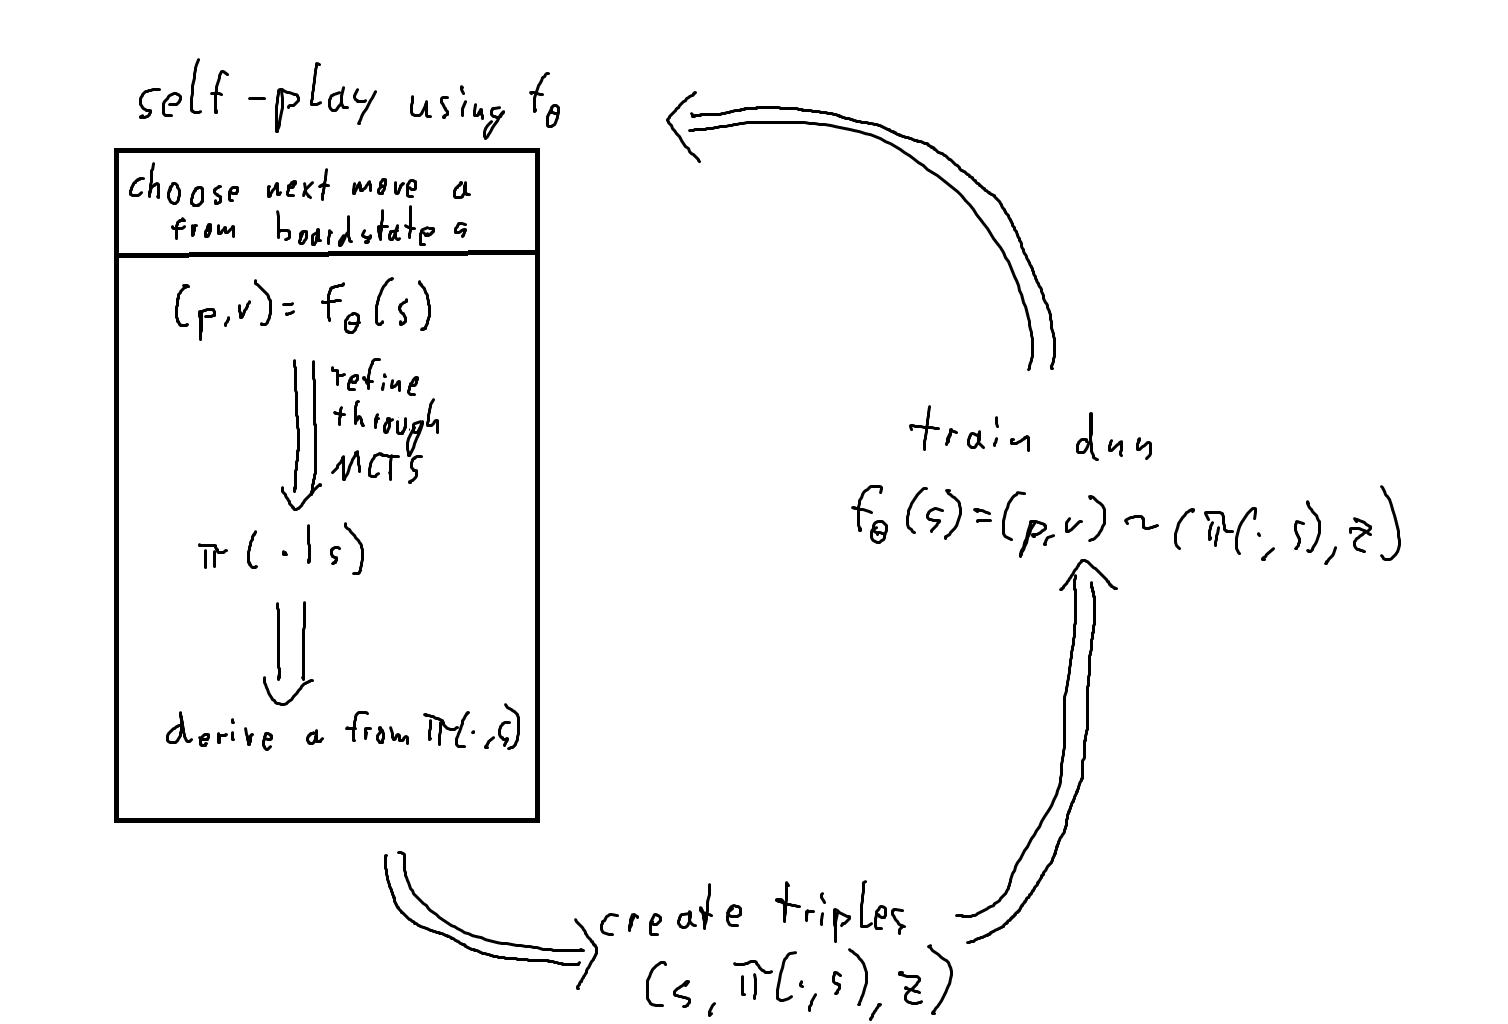

The deep neural network deployed in AlphaGo Zero is a residual neural network ([ResNet](https://en.wikipedia.org/wiki/Residual_neural_network)). In particular, the neural network in the original paper consisted of 40 residual blocks. These blocks were all randomly initilized at the start, meaning AlphaGo started learning without any prior knowledge and thus learned entirely through the self-play mechanism, requiring no human oversight.

## Results achieved by AlphaGo Zero

While starting off in training with significantly worse performance than a supervised RL approach, AlphaGo Zero quickly surpassed previous iterations of AlphaGo. This is shown in a graph from the original paper linked below, in which the performance during training was compared to supervised learning and AlphaGo Lee, the version which beat Lee Sedol, a major Go champion. 

The different approaches are compared using an elo system - a general rating of player strength. According to the graph the new RL approach surpasses the original supervised learning approach after approximately 20 hours. About 16 hours later it also surpassess AlphaGo Lee's elo rating. After a total of 72 hours the learning phase was completed and AlphaGo Zero beat AlphaGo Lee in a final clash of 100 matches without losing once.

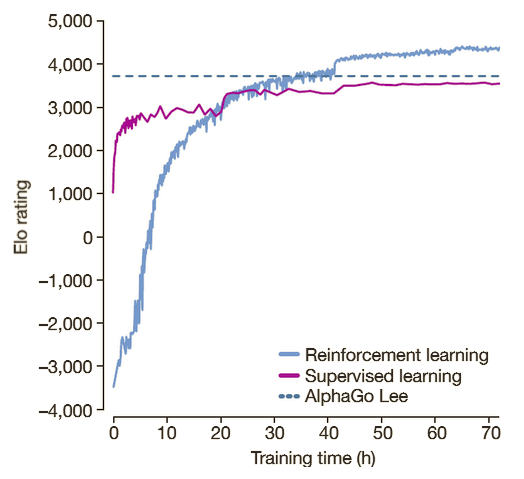

Another interesting observation regarding the prediction accuracy of moves played by professional human players suggests that AlphaGo Zero learns entirely different strategies and approaches of the game thus predicting human moves less accurate than the supervised learning method. The following graph illustrates this observation: AlphaGo Zero improves on this aspect while never reaching the supervised learning's accuracy which sits slightly above 50%. Despite this, researchers were also able to discover new improved variations of existing techniques by analyzing AlphaGo Zero's playstyle.

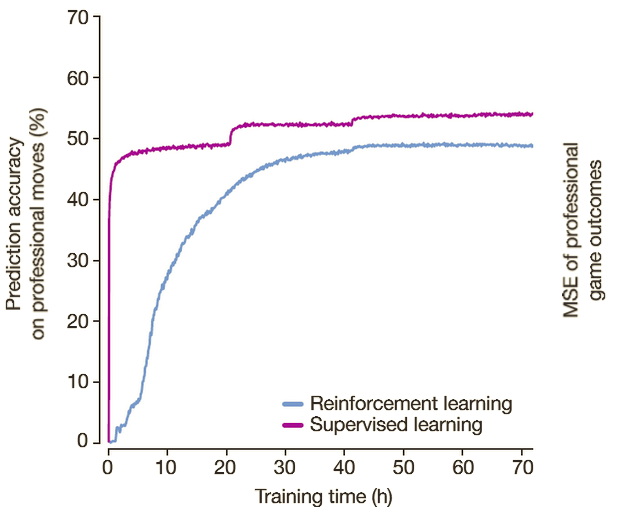

All of this suggests the viability of RL algorithms in complex fields and the ability of RL solutions to compete with and even surpass the knowledge accumulated by humans over thousands of years. Yet the work of the research team is far from finished. In this specific case the learning approach was applied to the popular game of Go but is substantially applicable to a wide range of games and problems. Therefore the next section will adapt AlphaGo's method for a different model: the game of Connect Four, thus demonstrating the flexibility of the approach.

## Exemplary results

By exchanging the model - in this case the rules of Go to Connect Four - and applying the discussed AlphaGo Zero learning approach the following results were observed over --- iterations with 30 episodes each: 

// Graphic

To evaluate the method at different stages of the learning process --- players competed in a tournament. Each player represents a different iteration and thus a different level of proficiency. During the tournament each player plays every player twice and gains/loses points equal to its wins/loses respectively (draws result in 0 points). The graphic illustrates the expected result that players representing a later stage of learning generally perform better than those representing earlier stages. 

// graphic tournament

This experiment shows that by simply exchanging the model AlphaGo Zero's technique can be applied to a variety of problems.

While AlphaGo Zero performs exceptionally well, it is still a model-based approach, thus requiring accurate knowledge of the environment (in this case the Go rules). This limits AlphaGo Zero's potential to be employed in more general applications as domain environment knowledge is often imperfect or missing entirely. Overcoming this is the goal of DeepMinds newest creation MuZero, which aims to learn the model of the environment instead of the model knowledge being given to the machine.

## References

- [Github](https://github.com/AppliedDataSciencePartners/DeepReinforcementLearning)
- [AlphaZero Cheatsheet](https://medium.com/applied-data-science/alphago-zero-explained-in-one-diagram-365f5abf67e0)
- [AlphaZero using Python and Keras](https://medium.com/applied-data-science/how-to-build-your-own-alphazero-ai-using-python-and-keras-7f664945c188)
- [Original Paper: Mastering the game of Go without human knowledge](https://www.nature.com/articles/nature24270.epdf?author_access_token=VJXbVjaSHxFoctQQ4p2k4tRgN0jAjWel9jnR3ZoTv0PVW4gB86EEpGqTRDtpIz-2rmo8-KG06gqVobU5NSCFeHILHcVFUeMsbvwS-lxjqQGg98faovwjxeTUgZAUMnRQ)